# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


Начнём с импорта необходимых библиотек. 

In [386]:
import pandas as pd
from os import listdir
import numpy as np
from pymystem3 import Mystem
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import word_tokenize, pos_tag 
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import torch
import transformers 
from tqdm import notebook
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Импортируем данные и познакомимся с ними. В первом датасете содержится информация о названии изображения и текстовом комментарии к нему. 

In [2]:
trainData = pd.read_csv('datasets/image_search/train_dataset.csv')

display(trainData.head(5))
trainData.info()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [3]:
print('Различных описаний: ', len(trainData.query_text.unique()))
print('Различных изображений: ', len(trainData.image.unique()))

display(trainData[trainData['image'] == '2549968784_39bfbe44f9.jpg'])

Различных описаний:  977
Различных изображений:  1000


,image,query_id,query_text
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4160,2549968784_39bfbe44f9.jpg,2490768374_45d94fc658.jpg#2,a young girl wearing blue smiles .
5134,2549968784_39bfbe44f9.jpg,2384353160_f395e9a54b.jpg#2,An older man in a weathered fedora smiles slig...
5137,2549968784_39bfbe44f9.jpg,3532205154_5674b628ea.jpg#2,A man with a shocked expression on his face is...


В файле с описаниями 5822 записи, уникальных описаний 977. Идентификатор описания на первый взгляд устроен не очень удобно, могут быть сложности с восстановлением взаимосвязи картинок друг с другом. 

Проверим, что идетификатор описания действительно является уникальным идентификатором описания. 

In [4]:
print(trainData[['query_text', 'query_id']].drop_duplicates().shape)
print(print(len(trainData.query_id.unique())))

(977, 2)
977
None


Идентификатор действительно является идентификатором, можем двигаться дальше. 

Импортируем данные, собранные с помощью крауд сорсинга.  

In [5]:
crowdEstimation = pd.read_csv('datasets/image_search/CrowdAnnotations.tsv', sep='\t', header=None)

In [6]:
display(crowdEstimation.head())

crowdEstimation.info()

,0,1,2,3,4
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       47830 non-null  object 
 1   1       47830 non-null  object 
 2   2       47830 non-null  float64
 3   3       47830 non-null  int64  
 4   4       47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


В датасете 47 830 пар картинка — описание. Это существенно больше, чем количество изначальных пар картинка - описание. Скорее всего, при сборе информации с помощью краудсорсинга пользователи получали описания, не относящиеся к изображению, и должны были их оценить. Такие оценки полезны, чтобы выделять заведомо не подходящие под описание картинки. 

Посмотрим подробнее на этот датасет. 

In [7]:
crowdEstimation.columns = ['image_id', 'query_id', 'part_correct', 'count_correct', 'count_wrong']

print('Количество описаний: ', len(crowdEstimation.query_id.unique()))
print('Количество изображений: ', len(crowdEstimation.image_id.unique()))

Количество описаний:  1000
Количество изображений:  1000


Среди оценок, собранных с помощью краудсорсинга есть пары, относящиеся к 1000 разлиных изображений и оценено 1000 различных комментариев. Однако, у нас есть тексты всего 977 комментариев, по остальным мы не можем получить полезной информации и записи надо исключить из рассмотрения. 

In [8]:
crowdEstimation = crowdEstimation[crowdEstimation.query_id.isin(trainData.query_id.unique())]

In [9]:
print('Количество описаний: ', len(crowdEstimation.query_id.unique()))
print('Количество изображений: ', len(crowdEstimation.image_id.unique()))

crowdEstimation.info()

Количество описаний:  977
Количество изображений:  1000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46721 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_id       46721 non-null  object 
 1   query_id       46721 non-null  object 
 2   part_correct   46721 non-null  float64
 3   count_correct  46721 non-null  int64  
 4   count_wrong    46721 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 2.1+ MB


Было удалено 1 100 записей, или чуть больше 2%. На текущем этапе это допустимые потери данных, тем более восстановить данные у нас возможности нет. Но в будущем при построении полноценной модели данные будет полезно восстановить, проконсультировавшись с тем, от кого они были получены. 

Исследуем, сколько пользователей оценивали каждый из комментариев при оценки комментариев с помощью краудсорсинга. 

In [10]:
crowdEstimation = crowdEstimation.reset_index(drop=True)

#crowdEstimation['total_count'] = ''
#crowdEstimation['compute_part'] = ''

crowdEstimation['total_count'] = crowdEstimation.count_correct + crowdEstimation.count_wrong
crowdEstimation['compute_part'] = abs(crowdEstimation.count_correct / crowdEstimation.total_count - 
                                      crowdEstimation.part_correct) < 0.01

display(crowdEstimation[crowdEstimation.compute_part == False].head())
print('Максимальное значение количества оценок: ', max(crowdEstimation.total_count))
print('Максимальное значение количества оценок: ', min(crowdEstimation.total_count))

,image_id,query_id,part_correct,count_correct,count_wrong,total_count,compute_part


Максимальное значение количества оценок:  6
Максимальное значение количества оценок:  3


Каждый комментарий сравнивало с картиной от 3 до 6 экспертов. Сравнение было бинарным и значение столбца "доля подтверждённых сообщений" получено как отношение положительных оценок к сумме положительных и отрицательных оценок. 

Посмотрим на статистику, по сколько оценок выставлялось для пары картинка - комментарий. 

In [11]:
crowdEstimation.groupby('total_count')['query_id'].agg('count')

total_count
3    45699
4      763
5      209
6       50
Name: query_id, dtype: int64

Для большинства комментариев оценки выставляло 3 пользователя. Будем ориантироваться на это значение и долю от количества положительных оценок как на вероятность, что комментарий совпал с картинкой. 

Оставим в датасете только нужные для дальнейшей работы столбцы: идентификаторы изображения и комментария, а так же выставленную оценку. 

In [12]:
crowdEstimationShort = crowdEstimation[['image_id', 'query_id', 'part_correct']]

Рассмотрим следующий датасет — оценки, выставленные экспертами. 

In [13]:
expertEstimation = pd.read_csv('datasets/image_search/ExpertAnnotations.tsv', sep='\t', header=None)
expertEstimation.columns = ['image_id', 'query_id', 'expert_1', 'expert_2', 'expert_3']

print('Количество описаний: ', len(expertEstimation.query_id.unique()))
print('Количество изображений: ', len(expertEstimation.image_id.unique()))

display(expertEstimation.head())

expertEstimation.info()

Количество описаний:  977
Количество изображений:  1000


,image_id,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


В датасете ожидаемое количество идентификаторов изображений и комментариев. 

Построим общий датасет, на основании которого построим целевой признак вероятности совпадения изображения и описания.

In [14]:
trainData.columns = ['image_id', 'query_id', 'query_text']

data = (
    trainData
    .merge(expertEstimation, on=['image_id', 'query_id'])
    .merge(crowdEstimationShort, on=['image_id', 'query_id'], how='outer')
)
display(data.head())
data.info()

,image_id,query_id,query_text,expert_1,expert_2,expert_3,part_correct
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.0,1.0,1.0,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.0,1.0,1.0,NaN
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.0,2.0,2.0,0.0
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,4.0,4.0,4.0,1.0
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.0,1.0,1.0,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 50213
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_id      50214 non-null  object 
 1   query_id      50214 non-null  object 
 2   query_text    5822 non-null   object 
 3   expert_1      5822 non-null   float64
 4   expert_2      5822 non-null   float64
 5   expert_3      5822 non-null   float64
 6   part_correct  46721 non-null  float64
dtypes: float64(4), object(3)
memory usage: 3.1+ MB


 Поправим датасет, чтобы текст комментария был в каждой строке. Сейчас в части строк есть только id комментария. 

In [15]:
data = data.drop('query_text', axis=1)
comments = trainData[['query_id', 'query_text']]
comments = comments.drop_duplicates().reset_index(drop=True)
data = data.merge(comments, on='query_id')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 50213
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_id      50214 non-null  object 
 1   query_id      50214 non-null  object 
 2   expert_1      5822 non-null   float64
 3   expert_2      5822 non-null   float64
 4   expert_3      5822 non-null   float64
 5   part_correct  46721 non-null  float64
 6   query_text    50214 non-null  object 
dtypes: float64(4), object(3)
memory usage: 3.1+ MB


Соответствие картинки и комментария может быть оценено: 
- только экспертами, в этом случае будем использовать среднюю оценку по 3 экспертам. 
- только с помощью краудинговых данных, в этом случае возьмём вероятность совпадения без изменения. 
- и экспертами и граудинговыми данными, в этом случае возьмём комбинацию двух оценок с коэффициентами 0.7 для экспертов и 0.3 для краудинговых данных. 

Итоговое значение вероятности поместим в поле target. 

In [16]:
data['target'] = 0.0

for i in range(data.shape[0]):
    # Вариант 1, нет экспертной оценки
    if np.isnan(data.loc[i, 'expert_1']):
        data.loc[i, 'target'] = data.loc[i, 'part_correct']
    # Вариант 2, есть оценки только экспертов
    elif np.isnan(data.loc[i, 'part_correct']):
        x1 = (data.loc[i, 'expert_1'] - 1.) / 3.
        x2 = (data.loc[i, 'expert_2'] - 1.) / 3.
        x3 = (data.loc[i, 'expert_3'] - 1.) / 3.
        data.loc[i, 'target'] = (x1 + x2 + x3) / 3.
    # Вариант 3, есть оба типа оценок
    else:
        x1 = (data.loc[i, 'expert_1'] - 1.) / 3.
        x2 = (data.loc[i, 'expert_2'] - 1.) / 3.
        x3 = (data.loc[i, 'expert_3'] - 1.) / 3.
        data.loc[i, 'target'] = 0.3 * data.loc[i, 'part_correct'] + 0.7 * (x1 + x2 + x3) / 3.

data.head()

,image_id,query_id,expert_1,expert_2,expert_3,part_correct,query_text,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1.0,1.0,1.0,0.0,A young child is wearing blue goggles and sitt...,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,1.0,1.0,1.0,NaN,A young child is wearing blue goggles and sitt...,0.000000
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,1.0,2.0,2.0,0.0,A young child is wearing blue goggles and sitt...,0.155556
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,4.0,4.0,4.0,1.0,A young child is wearing blue goggles and sitt...,1.000000
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,1.0,1.0,1.0,NaN,A young child is wearing blue goggles and sitt...,0.000000


Построили значение целевого признака, проверим, что значения попадают в интервал от 0 до 1. 

In [17]:
print(min(data.target), max(data.target))

0.0 1.0


**Вывод**. 

Обработали данные, рассчитали целевой признак. 

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Найдём список слов, которые могут свидетельствовать о том, что на картинке изображены дети до 16 лет. Возьмём только те пары картинка - описание, которые подходтяд друг к другу с вероятностью более 50%. 

In [18]:
len(data[data['target'] > 0.5]['query_text'].unique())

821

Почти все комментарии хотя бы раз использованы рядом с текстом, которому они соответствуют. Лемматизируем описания и выберем те слова, которые мы хотим исключить. 

In [19]:
wnl = WordNetLemmatizer()

def lemmatize(txt):
    return [wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(word_tokenize(txt))] #''.join(m.lemmatize(text, pos='v'))

lemmas = data[data['target'] > 0.5][['query_id', 'query_text']].drop_duplicates().reset_index(drop=True)

lemmas['lemmas'] =  ''
my_list = []

for i in range(lemmas.shape[0]):
    #try: 
    tmp = lemmatize(lemmas.loc[i, 'query_text'])
    my_list += tmp
    lemmas.loc[i, 'lemmas'] = ' '.join(tmp)
    #except:
    #    print(i, sep='')
    
my_list = list(set(my_list))
my_list.sort()

print(my_list)


['&', "'s", ',', '.', '12', '28', '4', '5', '58', ';', 'A', 'ATV', 'Albert', 'An', 'Arizona', 'Arts', 'Asian', 'BMX', 'Basketball', 'Black', 'Boat', 'Boys', 'Brown', 'Buena', 'Center', 'Challenge', 'Child', 'Children', 'Chinese', 'Christmas', 'Close-up', 'Collie', 'Crowded', 'DJs', 'Day', 'Dog', 'Dogs', 'Einstein', 'Five', 'Football', 'Four', 'Free', 'Friends', 'Frisbee', 'Girl', 'Girls', 'Gras', 'Group', 'Hawaiian', 'Hell', 'Hockey', 'Hugs', 'Incredible', 'Indian', 'Israeli', 'Jesus', 'Kids', 'Large', 'Little', 'Man', 'Many', 'Mardi', 'Men', 'Mexican', 'Miami', 'Mohawk', 'Muslim', 'Nash', 'Obama', 'One', 'Orca', 'Patricks', 'People', 'Person', 'Purina', 'Rafting', 'Real', 'SUV', 'Several', 'Sheltie', 'Small', 'Snowboarder', 'Some', 'Someone', 'Sooners', 'Spain', 'St', 'State', 'Steve', 'Team', 'The', 'Three', 'Tourists', 'Two', 'VW', 'Yerba', '``', 'a', 'about', 'above', 'across', 'action', 'actor', 'adult', 'aerial', 'after', 'against', 'age', 'ahead', 'aim', 'air', 'airborne', 'airp

In [96]:

'''stopWords = ['Boys', 'Child', 'Children', 
             'Girl', 'Girls', 'Kids', 'boy', 'child', 
             'kid', 'kiddie', 'children', 'girl', 'girls', 'young', 'youth']
'''

stopWords = ['Child', 'Children', 
             'Kids',  'child', 
             'kid', 'kiddie', 'children']

print()

In [97]:
def find_bad_comments(text):
    lemmasList = text.split()
    for word in stopWords:
        if word in lemmasList:
            return True
    return False

lemmas['is_bad'] = lemmas['lemmas'].apply(find_bad_comments)


In [98]:
lemmas[lemmas['is_bad'] == True].shape[0]

63

In [99]:
lemmas[lemmas['is_bad'] == True].head(10)

,query_id,query_text,lemmas,is_bad
0,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,A young child be wear blue goggles and sit in ...,True
4,3545652636_0746537307.jpg#2,A young boy dressed in a red uniform kicks the...,A young boy dress in a red uniform kick the so...,True
7,2140182410_8e2a06fbda.jpg#2,The kid is on a float in the snow .,The kid be on a float in the snow .,True
16,2358554995_54ed3baa83.jpg#2,A child is preparing to slide down a piece of ...,A child be prepare to slide down a piece of pl...,True
25,2274992140_bb9e868bb8.jpg#2,Two little children and one is playing with a ...,Two little child and one be play with a slinky .,True
46,3245460937_2710a82709.jpg#2,A child jumping on a tennis court .,A child jump on a tennis court .,True
58,3239021459_a6b71bb400.jpg#2,A child sleds over a mound of snow as others w...,A child sled over a mound of snow a others wat...,True
63,533713007_bf9f3e25b4.jpg#2,Child sitting at a backyard picnic table .,Child sit at a backyard picnic table .,True
69,2228022180_9597b2a458.jpg#2,Group of children in blue uniforms sitting on ...,Group of child in blue uniform sit on step .,True
76,3280052365_c4644bf0a5.jpg#2,Two woman and a child look at each other while...,Two woman and a child look at each other while...,True


63 описания погут подподать под нежелательные, в нашем случае это почти четверть выборки, что не очень хорошо. Просмотр текстов описаний демонстрирует, что они действительно подпадают под контент, который мы хотим исключить. 

На этапе исследования отбрасывания этой части данных неприятно, но так как для нас сейчас первична проверка гипотезы, то отбросим эти комментарии. 

In [106]:
badCommentsId = lemmas[lemmas['is_bad'] == True]['query_id'].to_list()
badImagesId = data[(data['query_id'].isin(badCommentsId) == True) & (data['target'] > 0.5)]['image_id'].to_list()
dataShort = data[data['image_id'].isin(badImagesId) == False].reset_index(drop=True)
print(len(list(set(badImagesId))))
dataShort.info()

114
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44299 entries, 0 to 44298
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_id      44299 non-null  object 
 1   query_id      44299 non-null  object 
 2   expert_1      5129 non-null   float64
 3   expert_2      5129 non-null   float64
 4   expert_3      5129 non-null   float64
 5   part_correct  41218 non-null  float64
 6   query_text    44299 non-null  object 
 7   target        44299 non-null  float64
dtypes: float64(5), object(3)
memory usage: 2.7+ MB


**Вывод** По описаниям, которые по ключевым словам определены как нежелательные, мы выбрали изображения, которые отмечены как подходящие под описание, и исключили их из рассмотрения. В общей сложности пришлось исключить 114 изображения. 

Выбрали более мягкий набор ключевых слов, чтобы было явное указание на слова kid / child, так как слова boy / girl в английском языке имееют широкий спектр смысло, не всегда относящихся к несовершеннолетним детям и при попытке добавить их в чёрный список пришлось бы удалить существенно больше половины всех изображений. 

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [181]:
ResNet50_model = ResNet50(input_shape=(224, 224, 3),
                         include_top=False,
#                         weights='imagenet')
                         weights='datasets/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

Импортировали пердобученную модель ResNet50 без слоёв, отвечающих за классификацию. Добавим ещё один слой глобального пулинга, чтобы уменьшить длинну вектора, который мы будем получать по изображению, это уменьшит время обучения нашей модели при проведении исследования.

In [333]:
modelImg = Sequential()
modelImg.add(ResNet50_model)
modelImg.add(GlobalAveragePooling2D())

modelImg.compile()
modelImg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [110]:
dataShortImageList = dataShort['image_id'].drop_duplicates().reset_index(drop=True)
print(dataShortImageList.shape[0])

886


Получили список из 886 изображений, которые надо пропустить через нейросеть, чтобы получить матрицу признаков. 

In [214]:
%%capture
tmp = []

for i in range(dataShortImageList.shape[0]):
    x = cv2.imread('datasets/image_search/train_images/' + dataShortImageList[i])
    x = cv2.resize(x, (224,224))
    x = x[...,::-1]
    y = []
    y.append(np.array(x))
    y = np.asarray(y)
    prediction = modelImg.predict(y)
    tmp.append(prediction[0])

In [257]:
dataImageVec = pd.DataFrame(tmp)

dataImageVec = pd.merge(dataImageVec, dataShortImageList, left_index=True, right_index=True)

display(dataImageVec.head())

dataImageVec.info()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,image_id
0,0.396763,0.000000,0.000000,0.992528,0.016766,0.157818,0.483455,1.276049,0.000000,2.241557,...,0.672824,1.877256,0.913814,0.288387,0.018386,0.382489,0.111324,0.382451,0.021998,1056338697_4f7d7ce270.jpg
1,0.170961,0.394343,0.146904,0.050207,0.022912,1.312894,0.647868,0.628595,0.000000,0.674256,...,0.533354,1.479692,1.372945,0.000000,0.260110,0.198910,0.496671,0.895046,0.323642,1262583859_653f1469a9.jpg
2,0.181983,0.862675,0.250075,0.028581,0.415757,0.073202,0.354051,1.896094,0.706087,1.114140,...,0.000000,0.258215,0.894780,0.110973,0.728838,1.038978,0.009464,1.358377,0.228356,2447284966_d6bbdb4b6e.jpg
3,0.346561,0.449940,0.000000,0.704483,0.458192,0.074307,0.186382,0.470730,0.066899,0.239818,...,0.553618,1.265478,1.079990,0.062393,0.000000,0.905175,0.094552,0.030488,0.980619,2621415349_ef1a7e73be.jpg
4,0.643673,1.921780,0.150075,1.769159,0.066529,0.001876,0.297507,1.658237,0.551048,0.000668,...,0.113651,0.991075,1.399973,1.376166,0.118803,0.180225,0.810359,0.529596,0.000000,3155451946_c0862c70cb.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886 entries, 0 to 885
Columns: 2049 entries, 0 to image_id
dtypes: float32(2048), object(1)
memory usage: 6.9+ MB


**Вывод**. 
Сделали векторизацию изображений, подготовили первый блок данных для обучения модели. 

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Векторизуем тексты. Выберем тексты, которые необходимо векторизовать. 

In [220]:
dataShort.columns

Index(['image_id', 'query_id', 'expert_1', 'expert_2', 'expert_3',
       'part_correct', 'query_text', 'target'],
      dtype='object')

In [223]:
dataText = dataShort[['query_id', 'query_text']].drop_duplicates().reset_index(drop=True)
dataText.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 977 entries, 0 to 976
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    977 non-null    object
 1   query_text  977 non-null    object
dtypes: object(2)
memory usage: 15.4+ KB


Векторизовать необходимо 977 различных комментариев. 

In [323]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
bertModel = transformers.BertModel.from_pretrained("bert-base-uncased") 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Для построения эмбэндингов необходимо сделать все буквы прописными. 

In [226]:
def lower_case(text):
    return text.lower()

dataText['query_text'] = dataText['query_text'].apply(lower_case)

Сделаем токенизацию текста. 

In [228]:
tokenized = dataText['query_text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

Настроим маску, которая описывает для модели, где у нас есть содержательные токены. 

In [232]:
padded = np.array([i + [0]*(512 - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

Сделаем векторизацию текста с помощью эмбэндингов. 

In [252]:
batch_size = 1
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = bertModel(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/977 [00:00<?, ?it/s]

In [253]:
textFeatures = np.concatenate(embeddings)
textFeatures.shape

(977, 768)

In [255]:
textFeatures = pd.DataFrame(textFeatures)
textFeatures = pd.merge(dataText, textFeatures, left_index=True, right_index=True)

print(textFeatures.shape)
textFeatures.head()


(977, 770)


,query_id,query_text,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,2549968784_39bfbe44f9.jpg#2,a young child is wearing blue goggles and sitt...,-0.047877,0.051415,-0.272813,-0.072299,0.047598,-0.743571,0.045497,0.837148,...,-0.365719,-0.110821,-0.342742,-0.105674,-0.026857,0.914322,0.184041,0.020953,0.323602,0.604958
1,2718495608_d8533e3ac5.jpg#2,a girl wearing a yellow shirt and sunglasses s...,0.306461,0.187397,-0.317479,-0.147754,0.092267,-0.241827,0.248197,0.775116,...,-0.326402,0.434386,-0.106929,0.084436,-0.069695,0.619139,0.204060,-0.192757,0.181119,0.577594
2,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .,0.225946,-0.147770,-0.410427,0.009857,0.024527,-0.012760,-0.160296,1.200930,...,-0.113069,-0.112948,-0.309222,-0.056991,0.130479,0.988332,-0.092634,-0.319207,0.430009,0.243055
3,3207358897_bfa61fa3c6.jpg#2,a woman plays with long red ribbons in an empt...,0.363719,0.163009,-0.490554,0.019928,0.072832,-0.125191,-0.251206,0.910355,...,-0.033179,0.282282,-0.214147,0.347063,0.388013,0.896650,0.471117,-0.301246,0.148654,0.346313
4,3286822339_5535af6b93.jpg#2,chinese market street in the winter time .,-0.368423,-0.235774,-0.305801,0.175350,0.182789,-0.072998,0.053588,1.238183,...,0.186065,-0.355032,-0.142533,0.475379,0.240221,-0.005224,-0.248849,-0.535116,0.498605,0.076597


**Вывод**.
Реализовали векторизацию текстов. В датафрэйм с векторизованными текстами добавили идентификатор текста, чтобы соотнести данные с векторизованными признаками для изображений. 

Теперь можем перейти к объединению признаков и обучению целевой модели. 

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

При обучении модели необходимо разбить данные на обучающую и валидационную выборки так, чтобы одно изображение не попадало в разные выборки. Таким образом, нам надо подготовить датафрейм, в котором будут: 
- идентификатор картинки
- векторизация картинки
- векторизация текста
- целевой признак

In [285]:
features = data[['image_id', 'query_id', 'target']]

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 50213
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image_id  50214 non-null  object 
 1   query_id  50214 non-null  object 
 2   target    50214 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.5+ MB


In [286]:
features = features.merge(textFeatures, on='query_id')

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 50213
Columns: 772 entries, image_id to 767
dtypes: float32(768), float64(1), object(3)
memory usage: 149.0+ MB


In [287]:
features = features.merge(dataImageVec, on='image_id')

features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44299 entries, 0 to 44298
Columns: 2820 entries, image_id to 2047
dtypes: float32(2816), float64(1), object(3)
memory usage: 477.6+ MB


In [288]:
features = features.drop(['query_id', 'query_text'], axis=1)

**Вывод**. 
Подготовили данные для обучения модели.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

Начнём с разбиения на тестовую и валидационную выборку. 

In [289]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)

indicesTrain, indicesValid = next(gss.split(X=features.drop(columns=['target']), 
                                              y=features['target'], 
                                              groups=features['image_id']))

target = features['target']
features = features.drop(['image_id', 'target'], axis=1)

featuresTrain, featuresValid = features.loc[indicesTrain], features.loc[indicesValid]
targetTrain, targetValid = target.loc[indicesTrain], target.loc[indicesValid]

Обучим модель линейной регрессии. В качестве метрики качества выберем RMSE. 

In [290]:
modelLR = LinearRegression()

modelLR.fit(featuresTrain, targetTrain)
score = mean_squared_error(targetValid, modelLR.predict(featuresValid), squared=False)
print('Значение RMSE для линейной модели на валидационной выборке равно', score)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Значение RMSE для линейной модели на валидационной выборке равно 0.20391990434307788


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [294]:
targetValid.head()

109    0.155556
110    0.000000
111    0.000000
112    0.000000
113    0.000000
Name: target, dtype: float64

Обучим ещё одну модель – модуль случайного леса. 

''' Перебор параметров для модели случайного леса
Даже для одного набора параметров модель учится достаточно долго на локальной машине, поэтому перебор пока за кадром. 
'''


score_values_forest = []
best_depth_forest = 0
best_number_est_forest = 0
best_score_forest = 1.

for i in range(10, 50, 5):
    for j in range(10, 25):
        model = RandomForestRegressor(n_estimators=i, max_depth=j, random_state=123, criterion='squared_error')
        model.fit(featuresTrain, targetTrain)
        score = mean_squared_error(targetValid, model.predict(featuresValid))
        score_values_forest.append([i, j, score])
        if score < best_score_forest:
            best_model_forest = model
            best_depth_forest = j
            best_number_est_forest = i
            best_score_forest = score
            print(i, j, score)

In [313]:
model = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=123, criterion='squared_error')
model.fit(featuresTrain, targetTrain)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RandomForestRegressor(max_depth=12, random_state=123)

In [315]:
errorVal = mean_squared_error(targetValid, model.predict(featuresValid), squared=False)
errorTrain = mean_squared_error(targetTrain, model.predict(featuresTrain), squared=False)
print(errorVal, errorTrain)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.19699297980089425 0.149977611357331


In [316]:
modelRF = model 

50 10 0.19 0.16
100 12 0.19 0.15

**Вывод**
Построили две самые простые модели: модель линейной регрессии и модель случайного леса. Попробуем проверить результат их работы.  

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [407]:
testQueries = pd.read_csv('datasets/image_search/test_queries.csv', sep='|')
testImages = pd.read_csv('datasets/image_search/test_images.csv')

In [408]:
display(testQueries.head())
testQueries.info()

,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


Выберем 10 случайных текстовых запросов. 

In [409]:
testQueries = testQueries.sample(10, random_state=321)
testQueries

,Unnamed: 0,query_id,query_text,image
310,310,3393035454_2d2370ffd4.jpg#0,a boy in a blue top is jumping off some rocks ...,3393035454_2d2370ffd4.jpg
69,69,2121140070_a09644550b.jpg#4,Men playing with a red ring out in the field .,2121140070_a09644550b.jpg
412,412,3690425778_3b390b3ea5.jpg#2,Person jumping into the water .,3690425778_3b390b3ea5.jpg
179,179,2885891981_6b02620ae9.jpg#4,The man is on a black and white bike .,2885891981_6b02620ae9.jpg
42,42,186346360_541047336f.jpg#2,A girl in a bikini top with a great view in th...,186346360_541047336f.jpg
114,114,2448210587_9fe7ea5f42.jpg#4,There is an older white haired lady and a bull...,2448210587_9fe7ea5f42.jpg
420,420,3730011701_5352e02286.jpg#0,A little girl buried in the sand .,3730011701_5352e02286.jpg
29,29,1468389504_c724bdcad0.jpg#4,two young girls wearing pink outfits playing o...,1468389504_c724bdcad0.jpg
84,84,2308256827_3c0a7d514d.jpg#4,The little boy is smiling as he crosses a rope...,2308256827_3c0a7d514d.jpg
28,28,1468389504_c724bdcad0.jpg#3,Two young girls on a playground .,1468389504_c724bdcad0.jpg


Построим эмбэндинги для текстов запросов из тестовой выборки. 

In [410]:
testQueries['query_text'] = testQueries['query_text'].apply(lower_case)

tokenized = testQueries['query_text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True))

padded = np.array([i + [0]*(512 - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

batch_size = 1
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = bertModel(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())
        
textFeaturesTest = np.concatenate(embeddings)
print(textFeaturesTest.shape)

textFeaturesTest = pd.DataFrame(textFeaturesTest)
testQueries = testQueries.reset_index(drop=True)
textFeaturesTest = pd.merge(testQueries, textFeaturesTest, left_index=True, right_index=True)

print(textFeaturesTest.shape)
textFeaturesTest.head()



  0%|          | 0/10 [00:00<?, ?it/s]

(10, 768)
(10, 772)


,Unnamed: 0,query_id,query_text,image,0,1,2,3,4,5,...,758,759,760,761,762,763,764,765,766,767
0,310,3393035454_2d2370ffd4.jpg#0,a boy in a blue top is jumping off some rocks ...,3393035454_2d2370ffd4.jpg,0.267639,0.131612,-0.391734,-0.177719,-0.116270,-0.871035,...,-0.395981,0.188154,-0.088772,-0.074415,0.039214,0.626259,0.151358,-0.090614,0.329404,0.484642
1,69,2121140070_a09644550b.jpg#4,men playing with a red ring out in the field .,2121140070_a09644550b.jpg,0.036916,-0.235343,-0.636791,0.267071,-0.245333,-0.432829,...,-0.240310,-0.171334,-0.402239,0.046431,0.519652,0.137858,-0.569222,-0.007875,0.182369,0.113385
2,412,3690425778_3b390b3ea5.jpg#2,person jumping into the water .,3690425778_3b390b3ea5.jpg,-0.757455,-0.348402,-0.347409,0.350174,-0.127449,-0.524127,...,0.162335,-0.214491,-0.218721,0.072327,0.451530,0.328309,0.115739,-0.373605,0.021721,-0.070855
3,179,2885891981_6b02620ae9.jpg#4,the man is on a black and white bike .,2885891981_6b02620ae9.jpg,-0.382840,0.309137,-0.354095,0.055012,0.096804,-0.342867,...,-0.150138,-0.010103,-0.198108,-0.161302,-0.118885,0.579964,-0.061727,0.032922,0.412005,0.310738
4,42,186346360_541047336f.jpg#2,a girl in a bikini top with a great view in th...,186346360_541047336f.jpg,0.027451,-0.198336,-0.386311,0.218691,0.131925,-0.160682,...,0.147100,-0.155101,-0.032204,0.219786,-0.034159,0.303100,0.017125,-0.426230,0.201643,-0.061901


Векторизуем все тестовые изображения. 

In [411]:
testImages.head()

,image
0,3356748019_2251399314.jpg
1,2887171449_f54a2b9f39.jpg
2,3089107423_81a24eaf18.jpg
3,1429546659_44cb09cbe2.jpg
4,1177994172_10d143cb8d.jpg


In [412]:
%%capture
tmp = []

for i in range(testImages.shape[0]):
    x = cv2.imread('datasets/image_search/test_images/' + testImages.loc[i, 'image'])
    x = cv2.resize(x, (224,224))
    x = x[...,::-1]
    y = []
    y.append(np.array(x))
    y = np.asarray(y)
    prediction = modelImg.predict(y)
    tmp.append(prediction[0])

In [413]:
dataImageVecTest = pd.DataFrame(tmp)

dataImageVecTest = pd.merge(dataImageVecTest, testImages, left_index=True, right_index=True)

display(dataImageVecTest.head())

dataImageVecTest.info()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,image
0,0.264200,2.319925,0.090116,0.000000,0.567073,0.847566,0.014415,0.192650,4.114438,0.701429,...,0.648174,1.297815,0.073208,0.000000,0.936226,0.000000,0.516047,0.011602,0.055812,3356748019_2251399314.jpg
1,0.560378,1.486012,0.052655,0.674691,0.923792,0.304759,0.367793,0.604801,0.318875,0.612532,...,0.411263,1.920577,0.592673,0.148314,0.497015,0.292336,0.000000,0.452958,0.112649,2887171449_f54a2b9f39.jpg
2,0.272928,0.981339,0.239474,0.011932,0.093311,0.662297,0.824766,0.348172,0.352599,0.409592,...,0.218256,1.837380,0.634010,0.399302,0.080383,0.010677,0.617424,1.183045,0.194922,3089107423_81a24eaf18.jpg
3,0.599542,0.579666,0.108110,0.008130,1.228424,3.090786,0.248327,0.492727,0.445221,0.193079,...,0.087671,0.225652,1.403060,0.000000,0.071296,0.032399,0.606897,0.987391,0.251437,1429546659_44cb09cbe2.jpg
4,0.177127,2.994261,0.048254,0.171363,1.172359,0.004302,0.004789,0.182754,0.006673,0.768340,...,0.050058,2.264112,0.805396,0.221277,0.004074,0.032894,3.500132,0.005787,0.611820,1177994172_10d143cb8d.jpg


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 2049 entries, 0 to image
dtypes: float32(2048), object(1)
memory usage: 800.9+ KB


Реализовали векторизацию изображений. Теперь для каждого из 10 комментариев, выбранных нами для тестирования моделей, построим 100 пар комментарий - изображение, проогоним через модель и выберем изображение с наибольшим значением признака.

При обучении моделей в начале были признаки, относящиеся к тексту, потом к изображению. 

Запустим для модели случайного леса. 

ID комментария:  3393035454_2d2370ffd4.jpg#0
Комментарий:  a boy in a blue top is jumping off some rocks in the woods .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


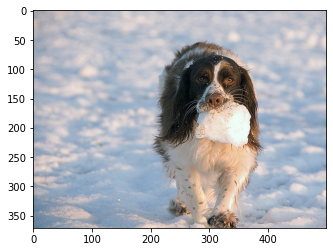

ID комментария:  2121140070_a09644550b.jpg#4
Комментарий:  men playing with a red ring out in the field .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


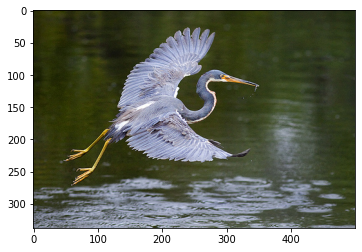

ID комментария:  3690425778_3b390b3ea5.jpg#2
Комментарий:  person jumping into the water .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


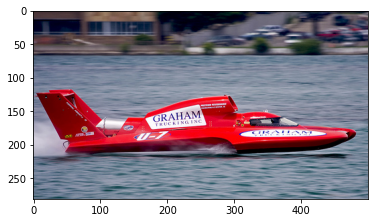

ID комментария:  2885891981_6b02620ae9.jpg#4
Комментарий:  the man is on a black and white bike .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


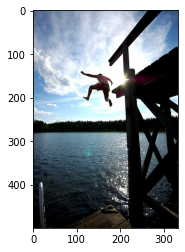

ID комментария:  186346360_541047336f.jpg#2
Комментарий:  a girl in a bikini top with a great view in the background


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


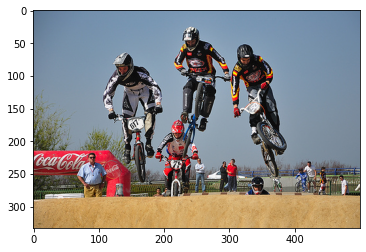

ID комментария:  2448210587_9fe7ea5f42.jpg#4
Комментарий:  there is an older white haired lady and a bulldog sitting on a tree stump .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


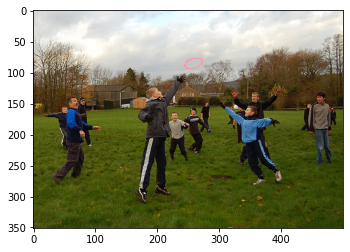

ID комментария:  3730011701_5352e02286.jpg#0
Комментарий:  a little girl buried in the sand .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


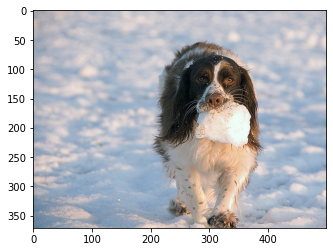

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


ID комментария:  1468389504_c724bdcad0.jpg#4
Комментарий:  two young girls wearing pink outfits playing on yellow monkey bars .


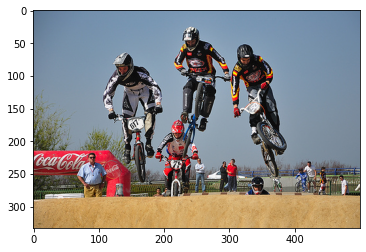

ID комментария:  2308256827_3c0a7d514d.jpg#4
Комментарий:  the little boy is smiling as he crosses a rope on an assault course .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


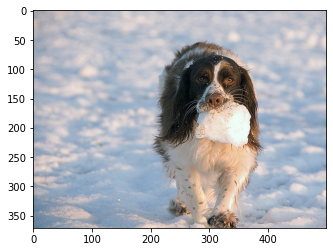

ID комментария:  1468389504_c724bdcad0.jpg#3
Комментарий:  two young girls on a playground .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


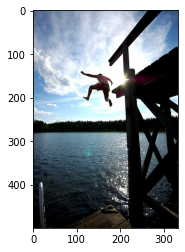

In [414]:
for i in range(10):
    queryID = textFeaturesTest.loc[i, 'query_id']
    print('ID комментария: ', queryID)
    print('Комментарий: ', textFeaturesTest.loc[i, 'query_text'])
    tmp = textFeaturesTest[textFeaturesTest['query_id'] == queryID]
    tmp = tmp.drop(['Unnamed: 0', 'query_id', 'query_text', 'image'], axis=1)

    tmp['key'] = 'key'
    dataImageVecTest['key'] = 'key'

    tmp = tmp.merge(dataImageVecTest, on='key')
    tmp = tmp.drop(['key', 'image'], axis=1)

    prediction = modelRF.predict(tmp)
    prediction = pd.DataFrame(prediction)
    prediction.columns = ['pred']
    imageNum = prediction['pred'].idxmax()
    imageName = testImages.loc[imageNum, 'image']

    img = mpimg.imread('datasets/image_search/test_images/' + imageName)
    imgplot = plt.imshow(img)
    plt.show()


Теперь запустим для модели линейной регрессии. 

ID комментария:  3393035454_2d2370ffd4.jpg#0
Комментарий:  a boy in a blue top is jumping off some rocks in the woods .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


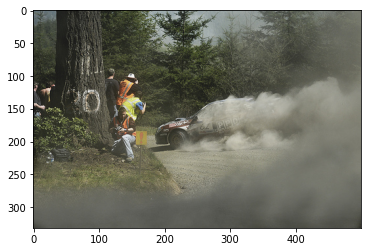

ID комментария:  2121140070_a09644550b.jpg#4
Комментарий:  men playing with a red ring out in the field .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


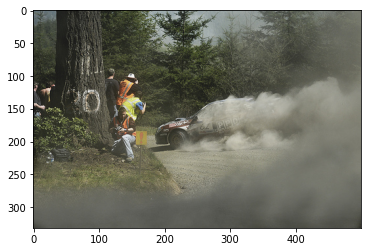

ID комментария:  3690425778_3b390b3ea5.jpg#2
Комментарий:  person jumping into the water .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


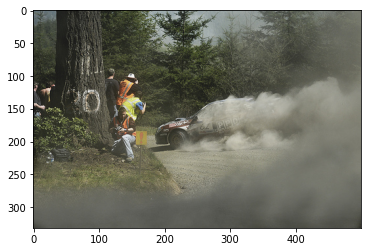

ID комментария:  2885891981_6b02620ae9.jpg#4
Комментарий:  the man is on a black and white bike .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


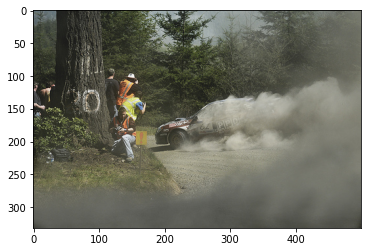

ID комментария:  186346360_541047336f.jpg#2
Комментарий:  a girl in a bikini top with a great view in the background


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


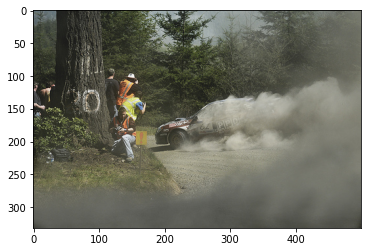

ID комментария:  2448210587_9fe7ea5f42.jpg#4
Комментарий:  there is an older white haired lady and a bulldog sitting on a tree stump .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


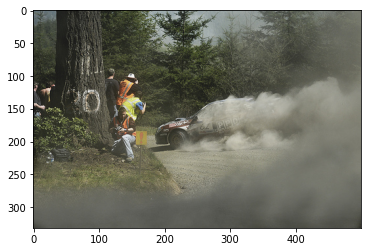

ID комментария:  3730011701_5352e02286.jpg#0
Комментарий:  a little girl buried in the sand .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


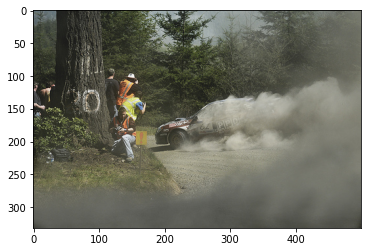

ID комментария:  1468389504_c724bdcad0.jpg#4
Комментарий:  two young girls wearing pink outfits playing on yellow monkey bars .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


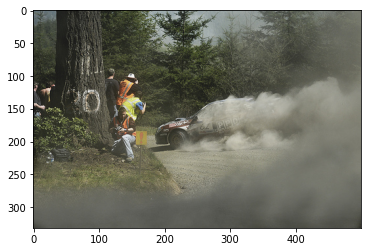

ID комментария:  2308256827_3c0a7d514d.jpg#4
Комментарий:  the little boy is smiling as he crosses a rope on an assault course .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


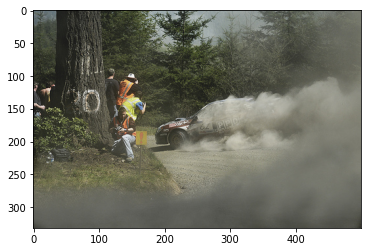

ID комментария:  1468389504_c724bdcad0.jpg#3
Комментарий:  two young girls on a playground .


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


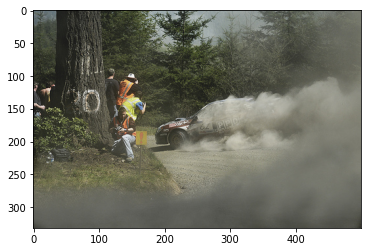

In [415]:
for i in range(10):
    queryID = textFeaturesTest.loc[i, 'query_id']
    print('ID комментария: ', queryID)
    print('Комментарий: ', textFeaturesTest.loc[i, 'query_text'])
    tmp = textFeaturesTest[textFeaturesTest['query_id'] == queryID]
    tmp = tmp.drop(['Unnamed: 0', 'query_id', 'query_text', 'image'], axis=1)

    tmp['key'] = 'key'
    dataImageVecTest['key'] = 'key'

    tmp = tmp.merge(dataImageVecTest, on='key')
    tmp = tmp.drop(['key', 'image'], axis=1)

    prediction = modelLR.predict(tmp)
    prediction = pd.DataFrame(prediction)
    prediction.columns = ['pred']
    imageNum = prediction['pred'].idxmax()
    imageName = testImages.loc[imageNum, 'image']

    img = mpimg.imread('datasets/image_search/test_images/' + imageName)
    imgplot = plt.imshow(img)
    plt.show()

**Вывод**
Проверили результат работы построенных моделей. 

Модель линейной регрессии показала себя плохо, хоть и быстро учится, но результат выдаёт одинаковый. 

Модель, построенная с использованием модели случайного леса повела себя существенно лучше: хоть и выдаёт случайный результат, но на картинках есть элементы из описания. 

На текущий момент это ещё не PoC для заказчика, но подтверждение того, что можно попробовать обучать более сложные модели, требующие больше вычислительных ресурсов. 

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска